In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [57]:
# import pandas as pd
# import numpy as np
from matplotlib import pyplot as plt
# from matplotlib.gridspec import GridSpec
import seaborn as sns
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
import sklearn
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel, SelectKBest, RFE, f_regression
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()

from sklearn import model_selection
# from sklearn import metrics, ensemble, linear_model
# import xgboost as xgb
# import catboost as cb
# import lightgbm as lgb
# from sklearn.experimental import enable_hist_gradient_boosting
# from sklearn.ensemble import HistGradientBoostingRegressor
# import warnings
# warnings.filterwarnings('ignore') 

font = {'size'   : 16}

plt.rc('font',**font)

# DATA INTAKE

In [49]:
features = pd.read_csv('features.csv')
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')

In [50]:
feature_store = features.merge(stores, how='inner', on = "Store")

df = train.merge(feature_store, how='inner', on = ['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

test_df = test.merge(feature_store, how='inner', on = ['Store','Date','IsHoliday']).sort_values(by = ['Store','Dept','Date']).reset_index(drop=True)

#  DATA CLEANING

In [51]:
# Missing Data on train dataset
print(df.isnull().sum())
missing = df.isnull().sum()


Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


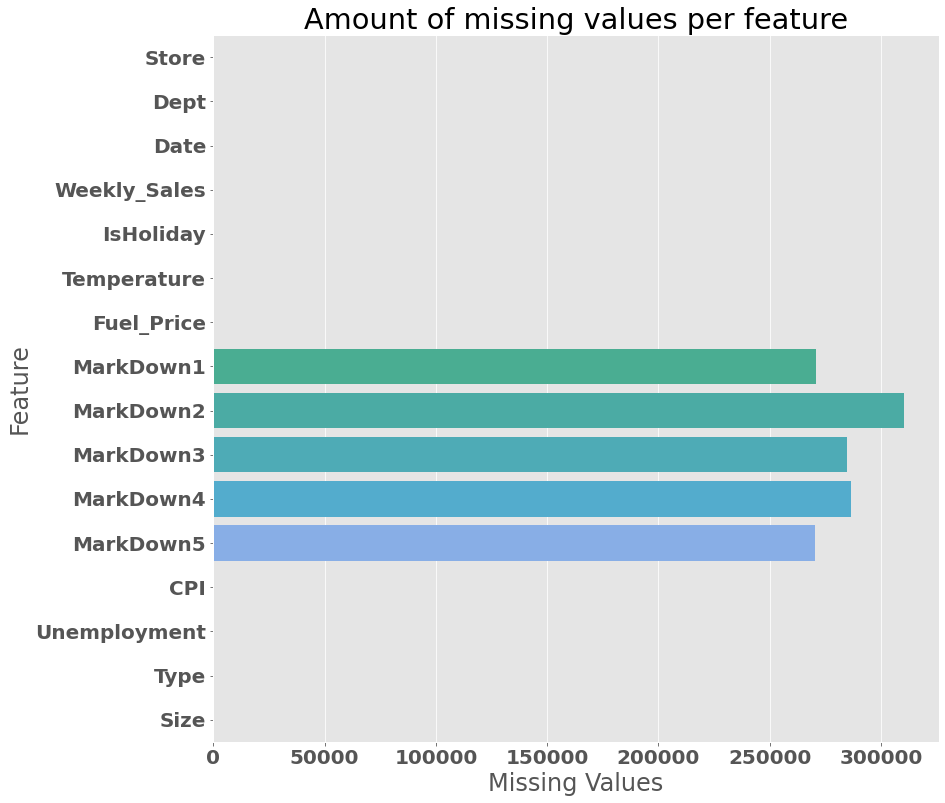

In [52]:
plt.figure(figsize=(13,13))


sns.barplot(x = missing.values, y  = missing.index)

plt.xlabel('Missing Values')
plt.ylabel('Feature')
plt.title('Amount of missing values per feature')
plt.savefig('MissingValues.png');

In [53]:
# Since MarkDowns are not constant it makes sense for there to be missing values. We are going to fill NaNs with 0
df = df.fillna(0)

In [54]:
# Missing Data on test dataset
print(test_df.isnull().sum())


Store               0
Dept                0
Date                0
IsHoliday           0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
Type                0
Size                0
dtype: int64


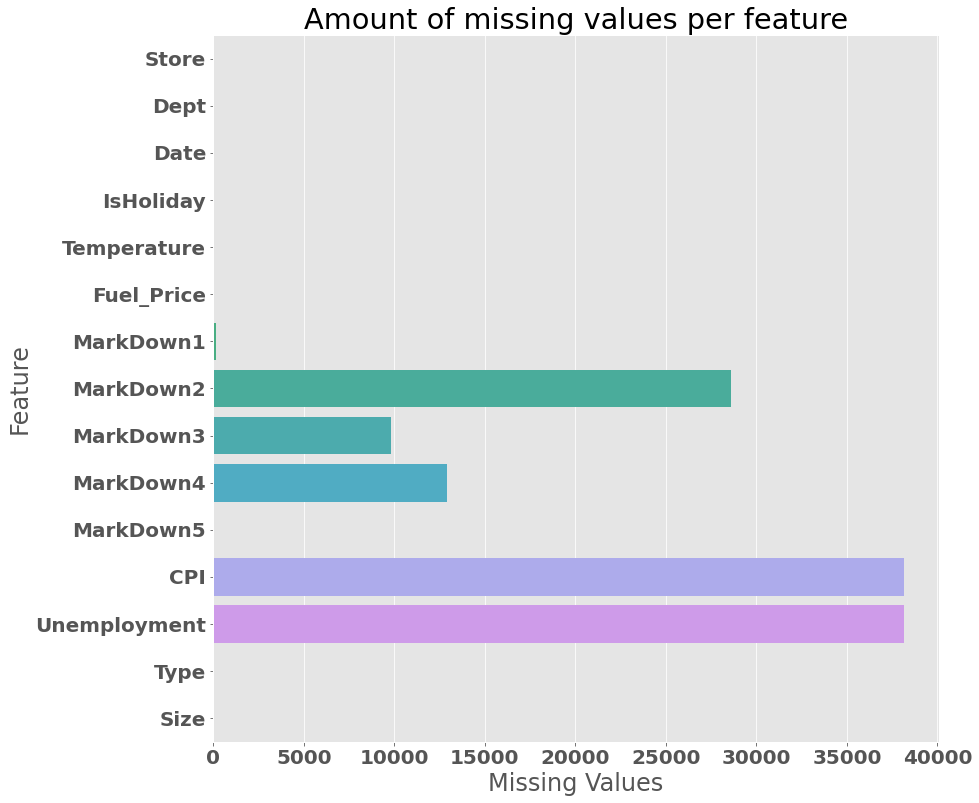

In [55]:
missing = test_df.isnull().sum()

plt.figure(figsize=(13,13))

plt.xlabel('Missing Values')
plt.ylabel('Feature')
plt.title('Amount of missing values per feature')




sns.barplot(x = missing.values, y  = missing.index)
plt.savefig('MissingValuesTest.png');


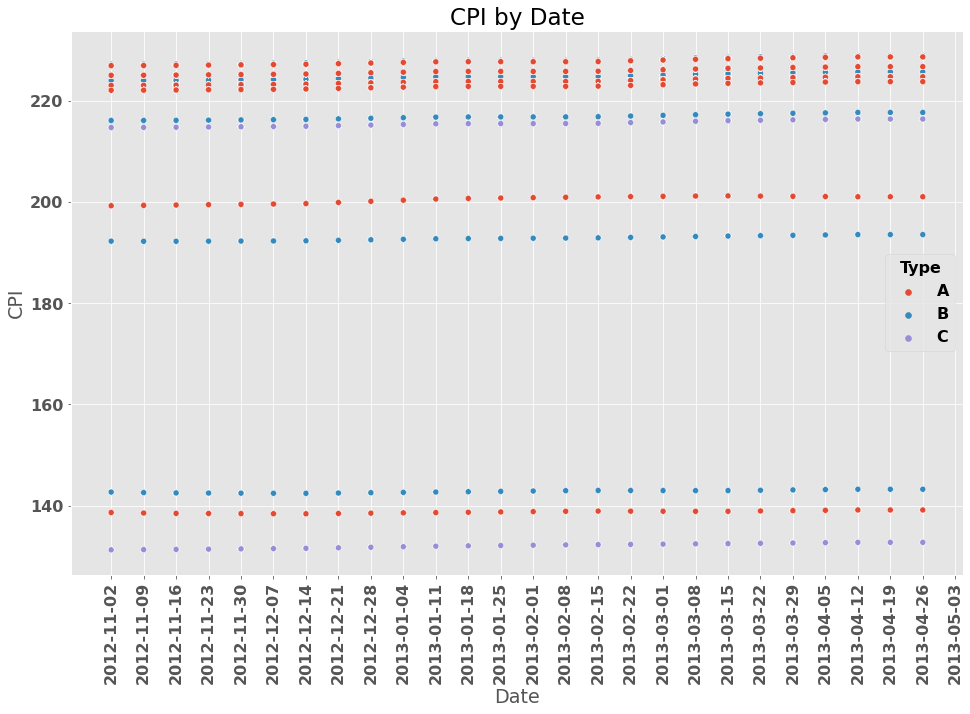

In [66]:
# Need to investigate CPI and Unemployment further to decide how we will impute these missing values
plt.figure(figsize=(16,10))
sns.scatterplot(data = test_df, x = 'Date', y = 'CPI', hue = 'Type')
plt.xticks(rotation = 90)
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('CPI by Date')
plt.show();

In [70]:
test_df.groupby('Store')['CPI'].count()[:10]

Store
1     1864
2     1871
3     1651
4     1870
5     1649
6     1865
7     1796
8     1799
9     1641
10    1863
Name: CPI, dtype: int64

In [73]:
test_df[(test_df.Store==1) &(test_df.CPI.isnull())]

Store  Dept        Date  IsHoliday  Temperature  Fuel_Price  MarkDown1  \
26        1     1  2013-05-03      False        66.66       3.386    2298.63   
27        1     1  2013-05-10      False        63.90       3.392    4624.61   
28        1     1  2013-05-17      False        69.53       3.454   16170.50   
29        1     1  2013-05-24      False        77.19       3.494    7959.89   
30        1     1  2013-05-31      False        78.02       3.466    2369.77   
...     ...   ...         ...        ...          ...         ...        ...   
2778      1    99  2013-06-07      False        76.44       3.439    3514.75   
2779      1    99  2013-06-14      False        79.86       3.431   12592.32   
2780      1    99  2013-07-05      False        79.85       3.422    7649.99   
2781      1    99  2013-07-19      False        79.26       3.556    3117.04   
2782      1    99  2013-07-26      False        81.54       3.620     332.17   

      MarkDown2  MarkDown3  MarkDown4  MarkDown5  CPI  Unemployment Type  \
26         2.00     129.90      55.46    1301.04  NaN           NaN    A   
27        83.88      42.38    1618.31    8144.90  NaN           NaN    A   
28        92.00       8.32    4127.24    6206.97  NaN           NaN    A   
29       178.00    1621.47    3152.57    2938.70  NaN           NaN    A   
30       142.45     475.35      45.55    2056.84  NaN           NaN    A   
...         ...        ...        ...        ...  ...           ...  ...   
2778     742.59     116.15    1015.44    5137.09  NaN           NaN    A   
2779     527.48     402.88    7474.56    2484.44  NaN           NaN    A   
2780    3503.29    1766.77    9454.96    1079.89  NaN           NaN    A   
2781    1060.39     199.05    1012.30    5381.72  NaN           NaN    A   
2782     673.19       1.00      38.63    1245.20  NaN           NaN    A   

        Size  
26    151315  
27    151315  
28    151315  
29    151315  
30    151315  
...      ...  
2778  151315  
2779  151315  
2780  151315  
2781  151315  
2782  151315  

[919 rows x 15 columns]

In [ ]:
# Since CPI data is regional it is store dependent and this is our proof that CPI depends on store. We can impute this missing data by filling
# missing values with the mean of the store which it belongs to

In [76]:
# Since CPI data is regional it is store dependent and this is our proof that CPI depends on store. We can impute this 
# missing data by filling missing values with the mean of the store which it belongs to
test_df['CPI'] = test_df.groupby('Store')['CPI'].transform(lambda value:  value.fillna(value.mean()))

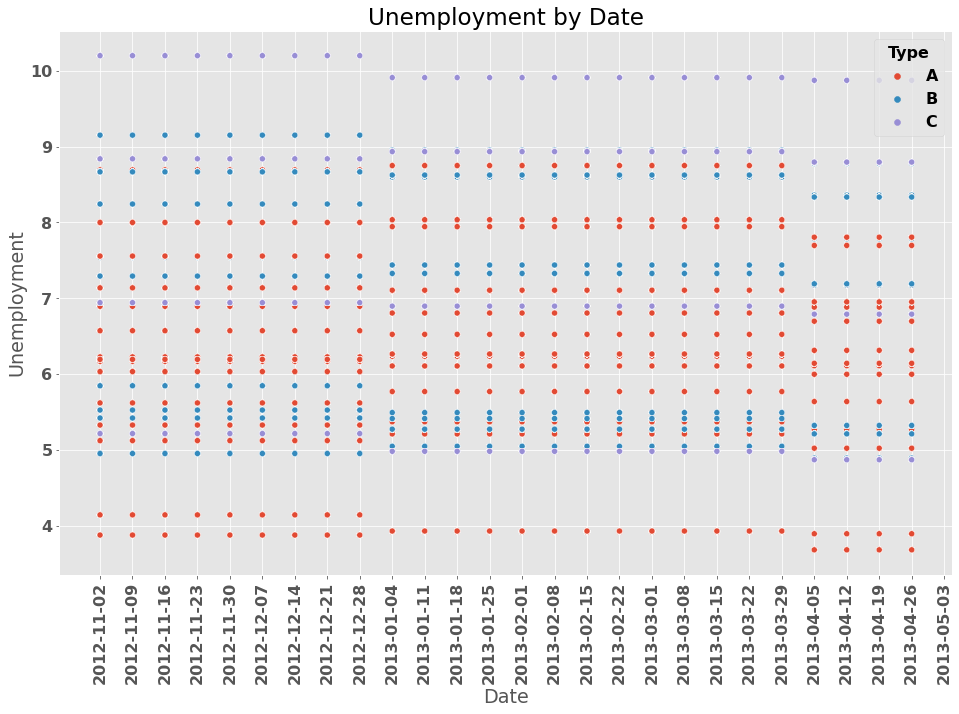

In [79]:
# Let's see if it is the same case for Unemployement
plt.figure(figsize=(16,10))
sns.scatterplot(data = test_df, x = 'Date', y = 'Unemployment', hue = 'Type')
plt.xticks(rotation = 90)
plt.xlabel('Date')
plt.ylabel('Unemployment')
plt.title('Unemployment by Date')
plt.show();

In [82]:
# Yes it is. Filling it the same way as CPI and then filling all MarkDowns as 0. No more missing values in either train
# or test dataset

In [84]:
test_df['Unemployment'] = test_df.groupby('Store')['Unemployment'].transform(lambda value: value.fillna(value.mean()))

In [86]:
# Since MarkDowns run throughout the year and are not guaranteed, missing values could mean that there was just no
# MarkDown that week for the given store and department
df = df.fillna(0)
test_df = test_df.fillna(0)

# DATA TYPES

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     421570 non-null  float64
 8   MarkDown2     421570 non-null  float64
 9   MarkDown3     421570 non-null  float64
 10  MarkDown4     421570 non-null  float64
 11  MarkDown5     421570 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [89]:
# Need to switch Date from an object to a datetime format and can also extract month, year, and week from it.
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df.Date.dt.year
df['Month'] = df.Date.dt.month
df['Day'] = df.Date.dt.day
df['WeekOfYear'] = (df.Date.dt.isocalendar().week)*1.0   
    
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['Year'] = test_df.Date.dt.year
test_df['Month'] = test_df.Date.dt.month
test_df['Day'] = test_df.Date.dt.day
test_df['WeekOfYear'] = (test_df.Date.dt.isocalendar().week)*1.0   

df = df.astype({'Year':'int32', 'Month':'int32', 'Day':'int32','WeekOfYear':'int32'})
test_df=test_df.astype({'Year':'int32', 'Month':'int32', 'Day':'int32','WeekOfYear':'int32'})

In [117]:
# Also going to switch the following columns to numeric in PREPROCESSING section
# IsHoliday, Type

# EDA

In [87]:
# Feature Overview
df.describe().transpose().style.background_gradient(cmap='OrRd')

In [119]:
# Biggest takeaways from this chart
# Huge outliers with max Weekly_Sales being (693/20)=35 times bigger than 75% of Weekly_Sales
# Big discrepancies between sizes of stores and Weekly_Sales
# Some stores actually lost money some weeks (-4988 in Weekly_Sales)
# Mean is much higher than 50% of Weekly_Sales further reinforcing the effect of outliers in the dataset
# Will have to use median when comparing Weekly_Sales

In [120]:
# TIME

In [121]:
# Let's see how sales are affected by different periods during the year

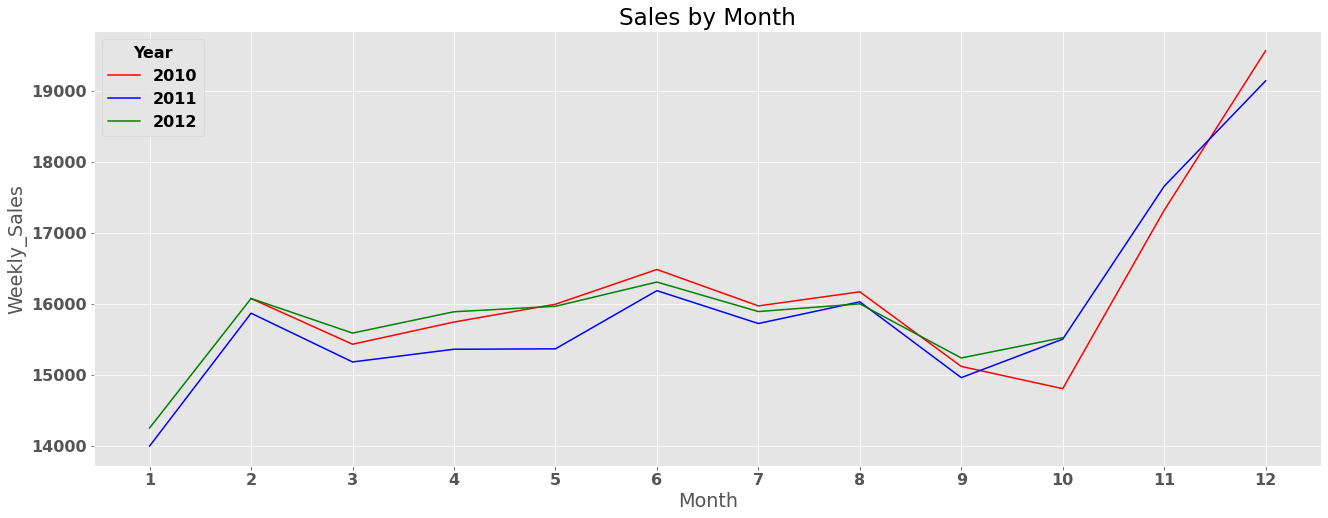

In [91]:
# How much sales each week?
plt.figure(figsize=(22,8))
sns.lineplot(data = df, x = 'Month', y = 'Weekly_Sales', hue = 'Year', ci = None, palette = ['r','b','g'])
plt.xticks(np.arange(1,13))
plt.title('Sales by Month');

In [21]:
# Starts off low because of the end of holidays and Feb-Aug stays pretty 
# consistent until a drop for Sept-Oct and then a rise in Nov-Dec
# So already we can see that sales are much more likely to be higher 
# in the last 2 months, lower in the first month, and average in between

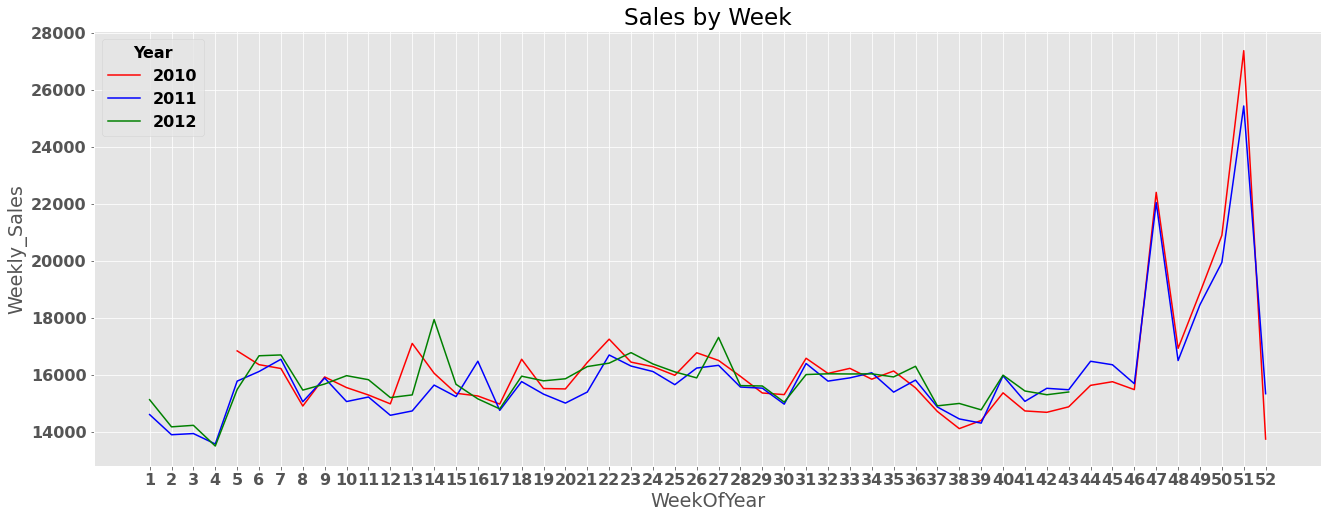

In [94]:
# How much sales each week?
plt.figure(figsize=(22,8))
sns.lineplot(data = df, x = 'WeekOfYear', y = 'Weekly_Sales', hue = 'Year', ci = None, palette = ['r','b','g'])
plt.xticks(np.arange(1,53))
plt.title('Sales by Week');

In [23]:
# # This view gives us a little more detail as we can now see a clear spike in week 47,
# a decrease in week 48 and then a gradual increase 
# # until sales peak on week 51. It may be better to 
# use this as a price predictor because it is more granular and will give us data 
# that is more specific

In [24]:
# STORE TYPE

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


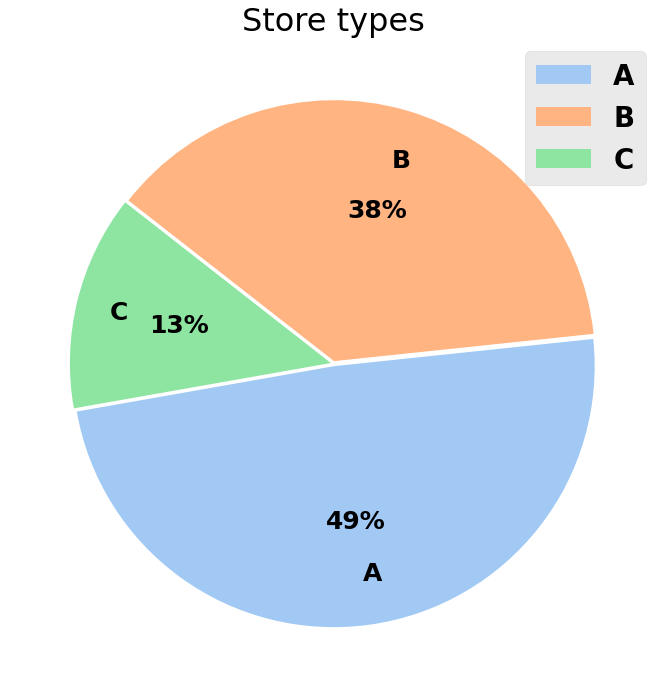

In [95]:
plt.figure(figsize=(12,12))
plt.pie(x = df.groupby('Type')['Store'].nunique().values, 
        labels = ['A','B','C'], colors = sns.color_palette('pastel'), 
        autopct='%.0f%%',labeldistance=0.8,wedgeprops=dict(width=1), 
        startangle=-170, textprops = dict(size = 25,), explode = (0.01, 0.01, 0.01) )
plt.title("Store types",fontsize = 32)
plt.legend(labels = ['A','B','C'], fontsize = 'xx-large');

In [26]:
# Most stores are Type A and B. Type C is a very small portion

In [96]:
# Adding labels to graphs


def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

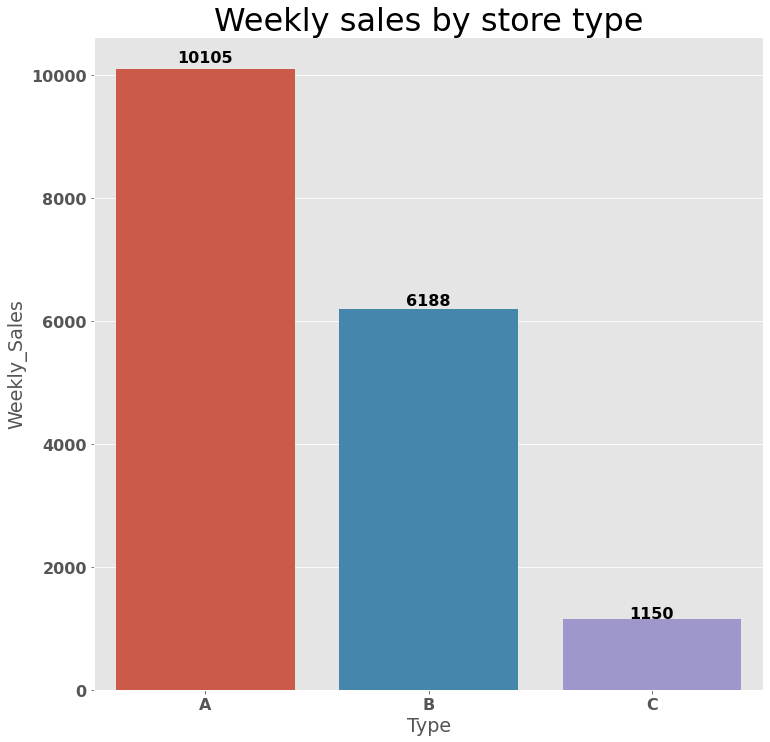

In [99]:
# How are store types different by sales?
plt.figure(figsize=(12,12))
plt.title("Weekly sales by store type",fontsize = 32)

ax = sns.barplot(data = pd.DataFrame(df.groupby('Type')['Weekly_Sales'].median().to_dict(), index = ['Weekly_sales']))
# for p in ax.patches:
#    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()-2),fontsize = 20);
show_values(ax)
plt.xlabel('Type')
plt.ylabel('Weekly_Sales')
plt.show();

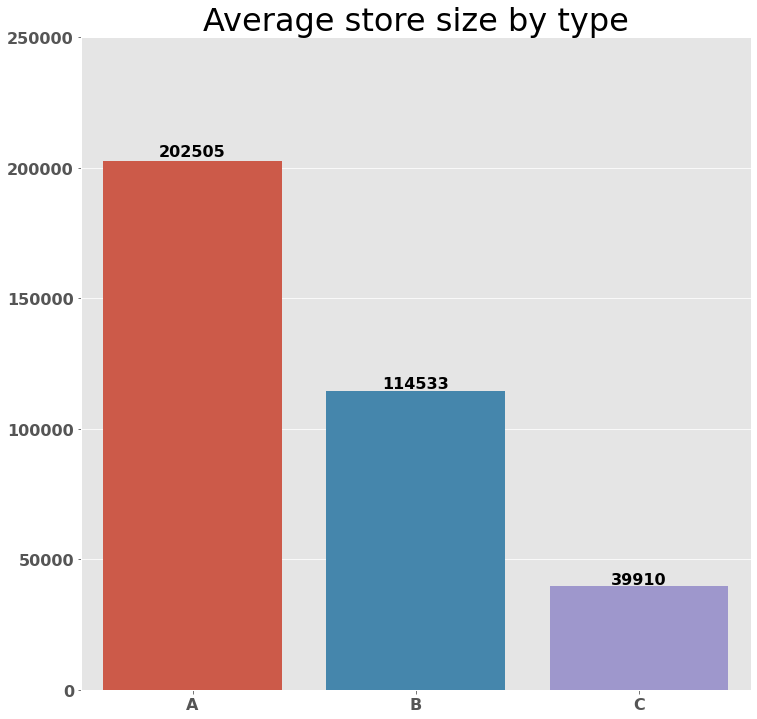

In [100]:
# If there is such a big variance between the median weekly sales of store types, there must also be some variance in their size.
plt.figure(figsize=(12,12))
ax = sns.barplot(data = pd.DataFrame(df.groupby('Type')['Size'].median().to_dict(), index = ['Type']))
plt.title("Average store size by type",fontsize = 32)
ax.set_ylim(top = 250000)
# for p in ax.patches:
#     ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()-2),fontsize = 20);
show_values(ax)

In [30]:
# Size of the store is very important in determining it's sales with the exception of certain weeks due to outliers and has a very clear 
# correlation

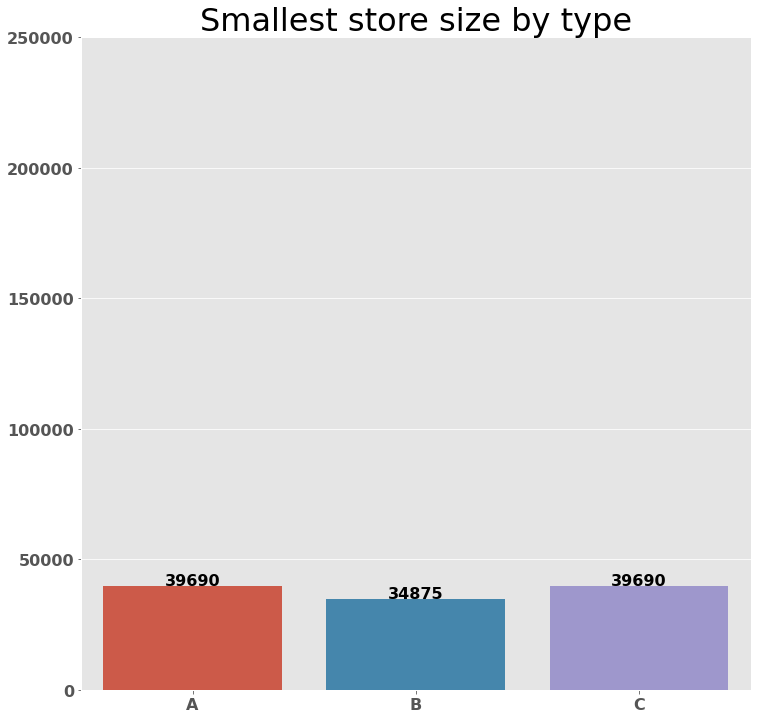

In [103]:
# How much variation is there in the sizes of a certain type of store?
plt.figure(figsize=(12,12))

ax = sns.barplot(data = pd.DataFrame(df.groupby('Type')['Size'].min().to_dict(), index = ['Type']))
ax.set_ylim(top = 250000)
plt.title("Smallest store size by type",fontsize = 32)

# for p in ax.patches:
#     ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()-2),fontsize = 20);
show_values(ax)

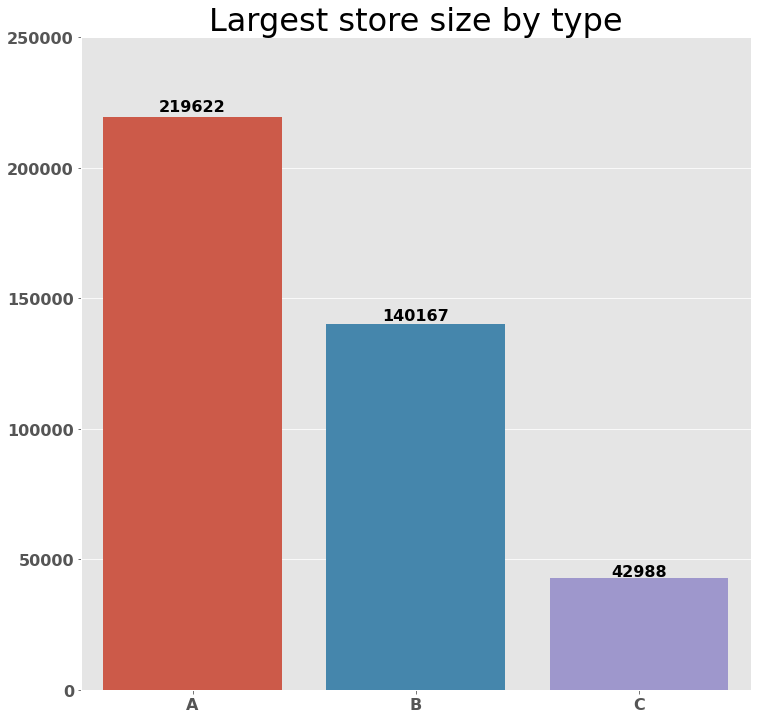

In [104]:
plt.figure(figsize=(12,12))
ax = sns.barplot(data = pd.DataFrame(df.groupby('Type')['Size'].max().to_dict(), index = ['Type']))
ax.set_ylim(top = 250000)
plt.title("Largest store size by type",fontsize = 32)

# for p in ax.patches:
#     ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()-2),fontsize = 20);
show_values(ax)

In [33]:
# Type C stores are pretty much all the same size but Type A and Type B are of all different sizes

Text(0.5, 1.0, 'Size to Sales ratio')

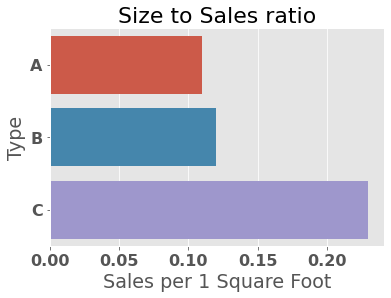

In [110]:
sales_by_size = round(df.groupby('Type')['Weekly_Sales'].mean()/df.groupby('Type')['Size'].mean(),2)
sales_by_size = sales_by_size.reset_index()
sales_by_size.rename( columns={0:'Sales per 1 Square Foot'} ,inplace=True)
ax = sns.barplot(data = sales_by_size, y = 'Type', x = 'Sales per 1 Square Foot')
plt.title("Size to Sales ratio",fontsize = 22)

In [120]:
typeA = df.groupby('Type')['Dept'].unique()[0]
TypeB = df.groupby('Type')['Dept'].unique()[1]
TypeC = df.groupby('Type')['Dept'].unique()[2]

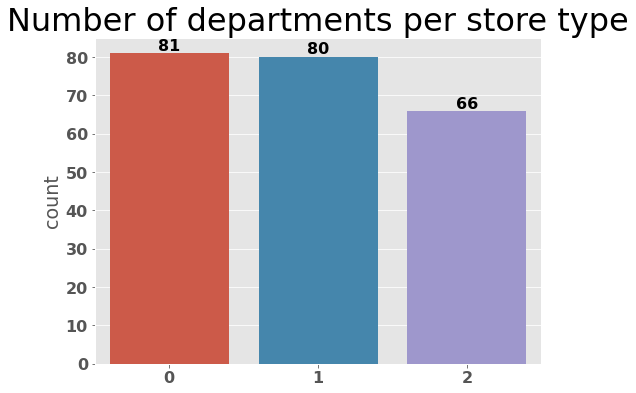

In [114]:
# If the average sizes of the store are so different based on type, then I would assume the number of departments is very different too
plt.figure(figsize=(8,6))
ax = sns.countplot(data = df.groupby('Type')['Dept'].unique())
# for p in ax.patches:
#    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.38, p.get_height()-2),fontsize = 20, color = 'w')
plt.title("Number of departments per store type",fontsize = 32)
show_values(ax);

In [36]:
# I guess not
# But since there is such a big difference in size between types, I would assume the missing department is also driving very high weekly sales.
# We will dive into departments later

In [37]:
# # Let's look at sales per store type throughout a year
# from numpy import median
# ax = sns.barplot(data =df[df.Year==2010] , x = 'Month', y ='Weekly_Sales', hue = 'Type', ci = None,estimator = median)

In [38]:
# ax = sns.barplot(data =df[df.Year==2011] , x = 'Month', y ='Weekly_Sales', hue = 'Type', ci = None,estimator = median)

In [39]:
# ax = sns.barplot(data =df[df.Year==2012] , x = 'Month', y ='Weekly_Sales', hue = 'Type', ci = None, estimator = median)
# ax.set_xlim(right = 12);

In [40]:
# Type A and B seem to follow the same pattern
#  Type C seems to not change at all throughout the year which is weird considering it's mean is much higher than it's median
# This is because there are type C stores that are outliers by their Weekly_Sales

In [41]:
# ax = sns.barplot(data =df[df.Year==2011] , x = 'Month', y ='Weekly_Sales', hue = 'Type', ci = None,estimator = max)

In [42]:
# Seeing as how the max of these Type A and B varies by Month but Type C doesn't, there has to be an outlier store and or department
# More on this when we get to the store and department section

<AxesSubplot:xlabel='Year,WeekOfYear'>

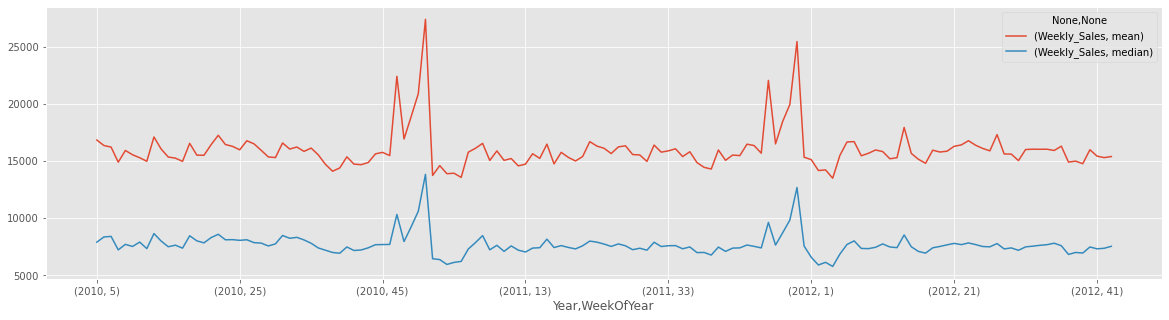

In [43]:
weekly_sales = df.groupby(['Year','WeekOfYear']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2010 = df.loc[df['Year']==2010].groupby(['WeekOfYear']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2011 = df.loc[df['Year']==2011].groupby(['WeekOfYear']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2012 = df.loc[df['Year']==2012].groupby(['WeekOfYear']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales.plot(figsize=(20,5))


In [44]:
# Store Id

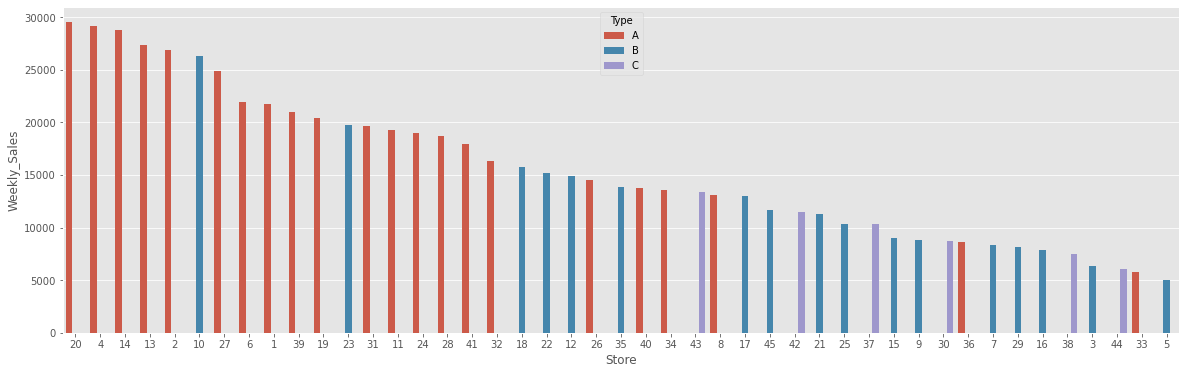

In [45]:
# As we caught a glimpse in the Type section, some stores are outliers when it comes to their weekly sales. Let's check this out in more detail.
stores = df.groupby(['Store','Type'])['Weekly_Sales'].mean().sort_values(ascending = False)
stores = stores.reset_index()
plt.figure(figsize=(20,6))
sns.barplot(x='Store',
            y="Weekly_Sales", 
            data=stores, 
            order=stores.sort_values('Weekly_Sales', ascending = False).Store, hue = 'Type');

In [46]:
# The prominent outliers when it comes to Weekly_Sales are Stores: 10,23,42,43 as being too high, and 3,5,33,36 as being too low

In [47]:
# # Let's see how stores perform throughout the years and if there is change in performance
# sns.barplot(data = df[df.Year==2010] , x ='Store', y ='Weekly_Sales',ci = None)
# plt.ylim(top = 35000)

In [48]:
# sns.barplot(data = df[df.Year==2011] , x ='Store', y ='Weekly_Sales',ci = None)
# plt.ylim(top = 35000)

In [49]:
# sns.barplot(data = df[df.Year==2012] , x ='Store', y ='Weekly_Sales',ci = None)
# plt.ylim(top = 35000)

In [50]:
# Not too much of a change in stores over the year. Have a couple of stores that peaked in 2010.


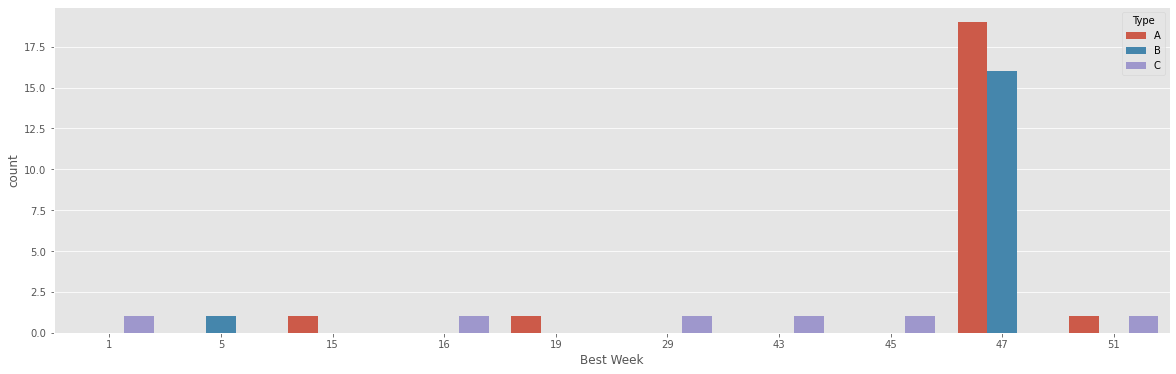

In [51]:
# Let's see what week of year each store sells the most
best_selling_dates = []
for i in range(1,46):
    best_selling_dates.append(df[df.Store==i].sort_values('Weekly_Sales', ascending = False).head(1)['WeekOfYear'].values[0])
    
best_selling = pd.DataFrame(index = range(1,46),data = best_selling_dates)
best_selling['Best Week'] = best_selling[0]
best_selling = best_selling.drop(0, axis = 1)
best_selling = best_selling.rename_axis('Store')
best_selling = best_selling.reset_index()
best_selling = best_selling.merge(stores, how ='inner', on ='Store')
best_selling = best_selling.drop('Weekly_Sales', axis = 1)

plt.figure(figsize=(20,6))
sns.countplot(data = best_selling, x = best_selling['Best Week'], hue = 'Type');

In [52]:
# Most stores have their best weeks around Christmas and are type A and B. Type C stores seem to not be affected by time of year in any way.
# Seeing how stores are able to peak at any time of year we can consider the df['Store'] feature an important predictor for Weekly_Sales 
# as some stores consitently perform above or below the average of their store Type 

In [53]:
# Departments

In [54]:
# # Which departments sell most/least on average?
# plt.figure(figsize=(20,14))
# sns.barplot(data = df, x = 'Dept', y = 'Weekly_Sales',ci = None);


In [55]:
# # And also by type?
# plt.figure(figsize=(20,14))
# sns.barplot(data = df, x = 'Dept', y = 'Weekly_Sales', hue = 'Type', ci = None);


In [56]:
# Seems C stores out sell B stores in departments 80,81,90,91,92,93,94,95,96,97,98 on a consistent basis
# On the contrary Type C's sales are next to nothing in some other departments like 72,74,3,5,7,9,10,11 compared to Type A and B meaning 
# some store types specialize in certain departments like store C in departments 80,81,90,91,92,93,94,95,96,97,98

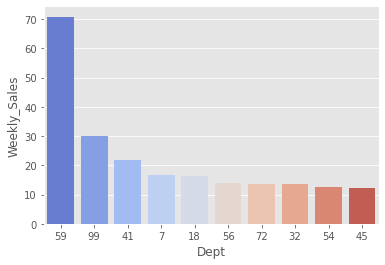

In [57]:
# Are some departments affected by seasons more than others?
seasonal_depts_ratio = (df.groupby("Dept")['Weekly_Sales'].max()/df.groupby("Dept")['Weekly_Sales'].mean()).sort_values(ascending=False)[:10].reset_index()
sns.barplot(data = seasonal_depts_ratio, 
            x = 'Dept', 
            y = 'Weekly_Sales', 
            order=seasonal_depts_ratio.sort_values('Weekly_Sales', ascending= False).Dept, palette = 'coolwarm');

In [58]:
# Department #59 generates 70 times more sales during a particular week than it does all other weeks

In [59]:
# plt.figure(figsize=(15,15))
# sns.barplot(data = df[df.Dept == 59], x = 'Month', y ='Weekly_Sales', ci = None,estimator = max )


In [60]:
# And it does so during December which is holiday season meaning some departments are affected by seasons more than others

45441.70622377621


<AxesSubplot:xlabel='Dept', ylabel='Difference'>

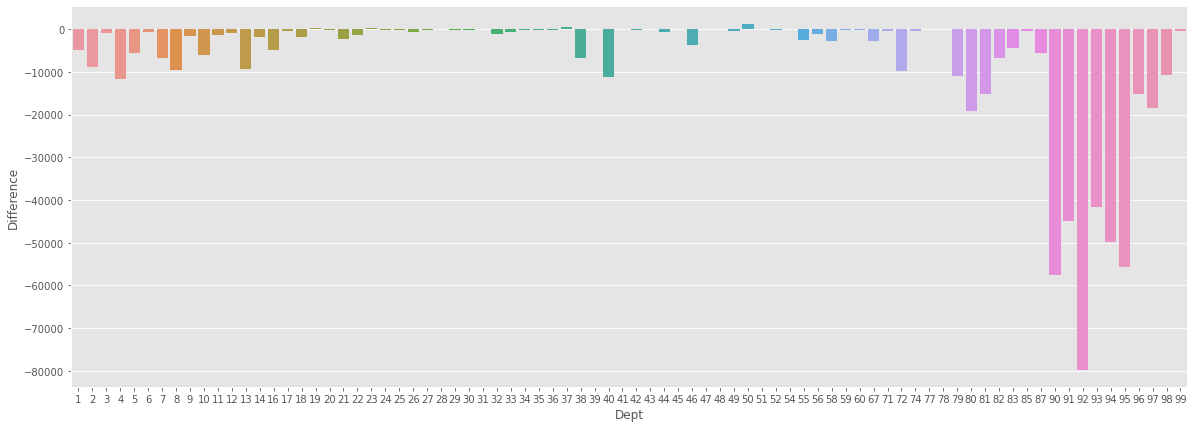

In [61]:
#DEPARTMENT BONUS

# Here are the departments that Type B has and Type C doesn't and how much they contribute to sales
# xXx = df[df.Dept==list(set(df[df.Type=='A']['Dept'].unique())-set(df[df.Type=='B']['Dept'].unique()))[0]]['Weekly_Sales'].mean()

# BC_diff = list(set(df[df.Type=='B']['Dept'].unique())-set(df[df.Type=='C']['Dept']))
# BC_diff_sales = []
# for i in BC_diff:
#     BC_diff_sales.append(df[df.Dept==i]['Weekly_Sales'].mean())
    
    
# plt.figure(figsize=(12,12))
# plt.bar(x = range(len(BC_diff_sales)), height = BC_diff_sales)

# Remember that Type A stores only have 1 more department than Type B stores but average much more sales?
# Let's see if that one department contributes to that in anyway

print(df[df.Dept==list(set(df[df.Type=='A']['Dept'].unique())-set(df[df.Type=='B']['Dept'].unique()))[0]]['Weekly_Sales'].mean())

df_type_b = df[df.Type=='B'].groupby('Dept')['Weekly_Sales'].mean().reset_index()
df_type_a = df[df.Type=='A'].groupby('Dept')['Weekly_Sales'].mean().reset_index()


df_dept_sales = df_type_b.merge(df_type_a, how = 'left', on ='Dept')
df_dept_sales['Weekly_Sales_x']
df_dept_sales.rename(columns = {'Weekly_Sales_x':'Weekly_Sales_B', 'Weekly_Sales_y':'Weekly_Sales_A'}, inplace = True)
df_dept_sales['Difference'] = df_dept_sales['Weekly_Sales_B']-df_dept_sales['Weekly_Sales_A']
plt.figure(figsize=(20,7))
sns.barplot(data =df_dept_sales, y = 'Difference', x ='Dept')


In [62]:
# Seems that Type A just outsells type B in every department
# And the missing department is averaging 45441.70

# We can see that df['Dept'] is a very important sales predictors as some departments are consistently bringing in the most Sales
# And combined with df['Date'] this predictor becomes powerful predictor of outliers

In [63]:

# MACRO ECONOMIC

In [64]:
# # First up is Fuel_price and it's affect on Weekly_Sales
# # Let's see Unemployment
# plt.figure(figsize=(15,15))
# sns.scatterplot(data = df , x = 'Fuel_Price' , y = 'Weekly_Sales', color = 'royalblue')
# plt.title( 'Weekly_Sales by Fuel price');

In [65]:
# No clear relationship between Fuel_Price and Weekly_Sales

In [66]:
# # Let's see Unemployment
# plt.figure(figsize=(15,15))
# sns.scatterplot(data = df , x = 'Unemployment' , y = 'Weekly_Sales', color = 'g')
# plt.title( 'Weekly_Sales by Unemployment rate');

In [67]:
# # Let's see CPI
# plt.figure(figsize=(15,15))
# sns.scatterplot(data = df , x = 'CPI' , y = 'Weekly_Sales', color = 'peru')
# plt.title( 'Weekly_Sales by CPI');

In [68]:
# # Let's see Temperature
# plt.figure(figsize=(15,15))
# sns.scatterplot(data = df , x = 'Temperature' , y = 'Weekly_Sales')
# plt.title( 'Weekly_Sales by Temperature (F)');

<AxesSubplot:ylabel='Correlation'>

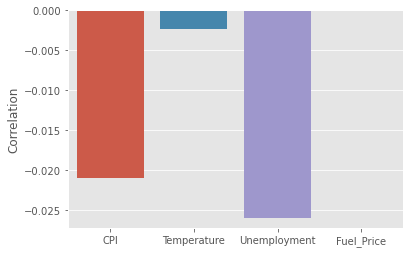

In [69]:
# Temperature is the most prominent of all Macro Economic factors with slight sales increase as temperature is higher
# Followed by a slight pattern of lower sales with higher unemployment rate
# Checking correlation values for these 4 will help us decide how to go about it
features = ['CPI','Temperature','Unemployment','Fuel_Price']
corrs = []

for feature in features:
    corrs.append(np.round(df['Weekly_Sales'].corr(df[feature]),4))

    
macro_corr_df = pd.DataFrame(corrs, columns =['Correlation'], index = features)
sns.barplot(data = macro_corr_df, y = 'Correlation', x = macro_corr_df.index)

C:\Users\User\AppData\Local\Temp/ipykernel_3228/3504131923.py:4: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



<AxesSubplot:title={'center':'Correlation Matrix'}>

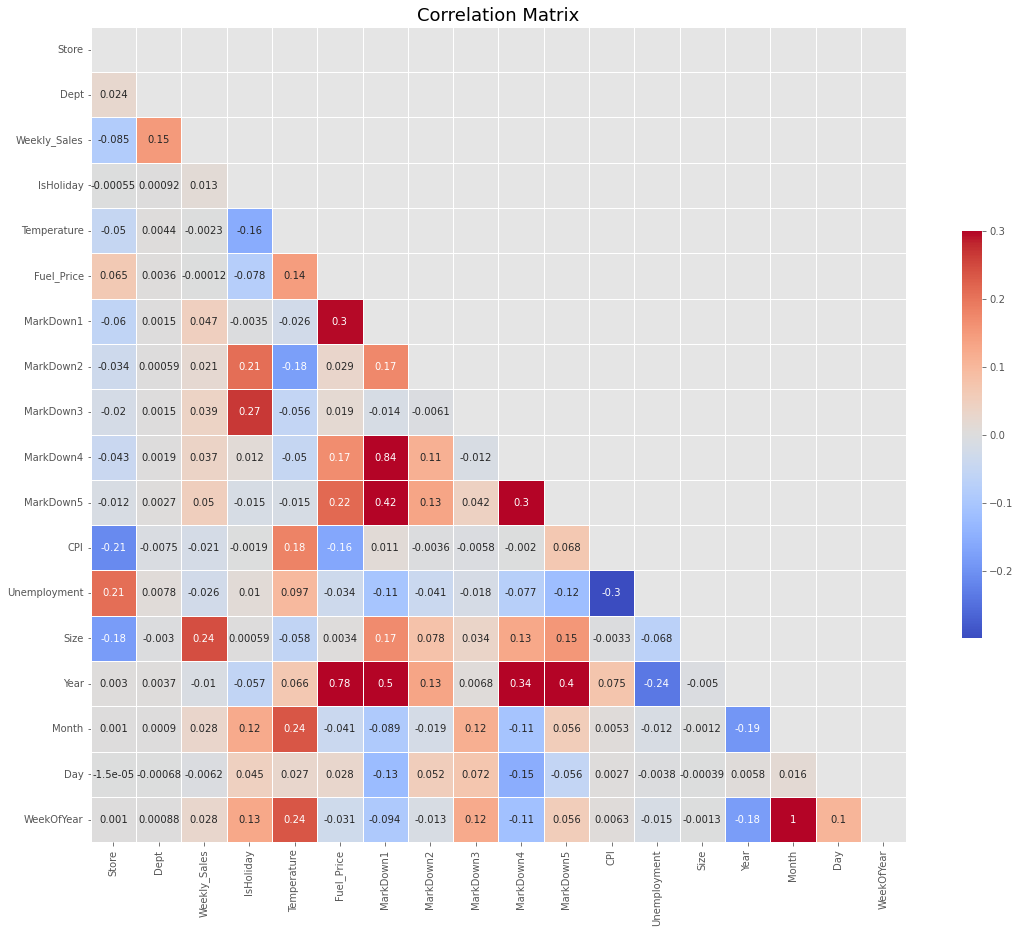

In [70]:
# Now that we got a taste of correlations let's do a deep dive on them
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)


In [71]:
import plotly.express as px
palette = px.colors.qualitative.Safe
weekly_sales_corr = df.corr().iloc[2,:]
corr_df = pd.DataFrame(data = weekly_sales_corr, index = weekly_sales_corr.index ).sort_values (by = 'Weekly_Sales', ascending = False)
corr_df = corr_df.iloc[1:]
bar = px.bar(corr_df, y = corr_df.index, x = 'Weekly_Sales', color=corr_df.index, labels={'index':'Featues'},
             title='Feature correlation with sales',color_discrete_sequence=palette)
bar.update_traces(showlegend=False)

In [72]:
# Most prominent correlations with Weekly_Sales are Dept and Size.
# Markdowns are a little pink but they are also very sparse in the data. Let's wait until feature importance to decide on those
# Markdowns on their own are pretty highly correlated so we should merge them into 1 field which marks their sum.
# Year is very highly correlated with Fuel_Price. We will need to get rid of Fuel_Price because Year is more important as it 
# tells apart weeks and months of different years
# It is weird that IsHoliday has low correlation with Weekly_Sales as that is when most sales happen

In [73]:
# Need to ispect holiday more
# Sales by holiday
holiday_sales = df.groupby('IsHoliday')['Weekly_Sales'].mean()
holiday_sales = holiday_sales.reset_index()
holiday_count = df.groupby('IsHoliday')['Weekly_Sales'].count()
holiday_count = holiday_count.reset_index()

In [74]:
# sns.barplot(data = holiday_sales, x = 'IsHoliday', y ='Weekly_Sales')

In [75]:
# sns.barplot(data = holiday_count, x = 'IsHoliday', y ='Weekly_Sales')

In [76]:
# Despite being a very small portion of the year, holidays consistently outsell non-holidays so we will include this feature

# FEATURE ENGINEERING AND PREPROCESSING

In [77]:
# Here are some of my ideas for feature engineering

# Add more holidays like:
# 4th of july
# Easter
# November 25	Black Friday
# November 28	Cyber Monday

def create_holiday_type_column(df, dates, holiday_type, name):
    df.loc[
    df['Date'].isin(dates),
    'HolidayType'
    ] = holiday_type



df['HolidayType'] = -1
test_df['HolidayType'] = -1
    
holiday_list = [
        (['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'], 'Super_Bowl'),
        (['2010-09-10','2011-09-09', '2012-09-07', '2013-09-06'], 'Labor_Day'),
        (['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'], 'Thanksgiving/BlackFriday'),
        (['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'], 'Christmas'),
        (['2010-04-09', '2011-04-29', '2012-04-13', '2013-03-29'], 'Easter'),
        (['2010-07-09', '2011-07-08', '2012-07-06', '2013-07-05'], '4thJuly'),
        (['2010-12-03', '2011-11-02', '2012-11-30', '2013-12-06'], 'CyberMonday')]
    
for index in range(0, len(holiday_list)):
    holiday = holiday_list[index]
    create_holiday_type_column(df, holiday[0], index, holiday[1])
    
for index in range(0, len(holiday_list)):
    holiday = holiday_list[index]
    create_holiday_type_column(test_df, holiday[0], index, holiday[1])
    

# This has added holiday to both train and test set

In [78]:
# Adding 'days to Christmas' and Thanksgiving as people are probably shopping lots before these holidays and not just the week before

df['Days_to_Christmas'] = (pd.to_datetime(df["Year"].astype(str)+"-12-24", format="%Y-%m-%d") - pd.to_datetime(df["Date"], format="%Y-%m-%d")).dt.days.astype(int)    
df['Time_to_Christmas'] = df['Days_to_Christmas'].apply( lambda x: 1 if x < 61 else (2 if x< 90 else 3))
test_df['Days_to_Christmas'] = (pd.to_datetime(test_df["Year"].astype(str)+"-12-24", format="%Y-%m-%d") - pd.to_datetime(test_df["Date"], format="%Y-%m-%d")).dt.days.astype(int)
test_df['Time_to_Christmas'] = test_df['Days_to_Christmas'].apply( lambda x: 1 if x < 61 else (2 if x< 90 else 3))


df['Days_to_Thansksgiving'] = (pd.to_datetime(df["Year"].astype(str)+"-11-24", format="%Y-%m-%d") - pd.to_datetime(df["Date"], format="%Y-%m-%d")).dt.days.astype(int)
test_df['Days_to_Thansksgiving'] = (pd.to_datetime(test_df["Year"].astype(str)+"-11-24", format="%Y-%m-%d") - pd.to_datetime(test_df["Date"], format="%Y-%m-%d")).dt.days.astype(int)
df['Time_to_Thanksgiving'] = df['Days_to_Thansksgiving'].apply( lambda x: 1 if x < 14 else (2 if x< 21 else 3))
test_df['Time_to_Thanksgiving'] = test_df['Days_to_Thansksgiving'].apply( lambda x: 1 if x < 14 else (2 if x< 21 else 3))

In [79]:

# Changing Type from object to numeric
df['Ntype'] = df['Type'].apply(lambda x: 1 if x == 'A' else (2 if x == 'B' else 3))
test_df['Ntype'] = test_df['Type'].apply(lambda x: 1 if x == 'A' else (2 if x == 'B' else 3))

# Changing holiday from boolean to numeric
df['IsHoliday'] = df['IsHoliday'].apply(lambda x: 1 if x == True else 0)
test_df['IsHoliday'] = test_df['IsHoliday'].apply(lambda x: 1 if x == True else 0)

In [80]:
# As MarkDowns have a little bit of correlation to Weekly_Sales we can aggregate them per store 
# in the new feature called SaleAmount and add a feature which states when there is a sale or not


df['SaleAmount'] = df['MarkDown1'] + df['MarkDown2'] + df['MarkDown3'] + df['MarkDown4'] + df['MarkDown5'] 
test_df['SaleAmount'] = test_df['MarkDown1'] + test_df['MarkDown2'] + test_df['MarkDown3'] + test_df['MarkDown4'] + test_df['MarkDown5']

df['IsSale'] = df['SaleAmount'].apply(lambda x: 1 if x >0  else 0)
test_df['IsSale'] = test_df['SaleAmount'].apply(lambda x: 1 if x >0  else 0)

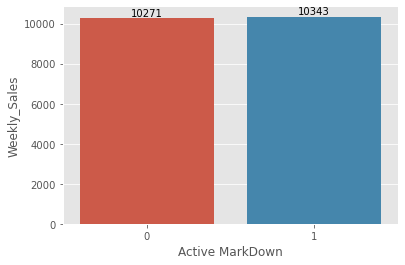

In [81]:
# Lets see if having a markdown has anything to do with changes in Weekly_Sales. Using median since sales have had such huge outliers
from numpy import median
ax = sns.barplot(data = df[df.Store==1] , x ='IsSale', y ='Weekly_Sales', ci = None, estimator = median)
plt.xlabel('Active MarkDown')
show_values(ax)

In [82]:
# Weekly_Sales seem to remain the same regardless if a store is running a markdown event or not

In [83]:
# # Let's see how Weekly_Sales change depending on MarkDown amount for one store
# plt.figure(figsize=(14,14))
# sns.scatterplot(data = df[(df.Store==1)] , x ='SaleAmount', y ='Weekly_Sales', hue = 'Dept')

In [84]:
# Weekly Sales don't seem to depend much on whether there is an active markdown or not in this store

In [85]:
# # Let's see if that store was an outlier
# plt.figure(figsize=(16,12))
# sns.scatterplot(data = df , x = 'Weekly_Sales', y ='SaleAmount', hue = 'Store', alpha = 1)

In [86]:
# Seems that sales are more dependent on the store Id rather than MarkDown. 
# Some stores are going to sell more no matter what kind of MarkDowns their competitors are running

In [87]:
# # Let's compare sales with markdown events and non-markdown events
# plt.figure(figsize=(20,15))
# sns.barplot(data = df, x = 'Month', y = 'Weekly_Sales', hue = 'IsSale', ci=None, estimator = median)


In [88]:
# # It is still too hard to tell if MarkDowns drive sales as only 8 out of the 12 months do stores with markdown events outsell
# # stores without markdown events.

# # Here is an example of 2 stores where markdown consistently drive more sales and where markdowns consistently lose sales
# plt.figure(figsize=(20,15))
# sns.barplot(data = df[df.Store==42] , x = 'Month', y = 'Weekly_Sales', hue = 'IsSale', ci=None, estimator = median)
# plt.title('Store 42')

In [89]:
# # And here is the opposite case
# plt.figure(figsize=(20,15))
# sns.barplot(data = df[df.Store==1] , x = 'Month', y = 'Weekly_Sales', hue = 'IsSale', ci=None, estimator = median)
# plt.title('Store 1')

In [90]:
# This points to the idea that some stores offer markdowns proactively and some offer them reactively.
# Meaning some use it to get rid of old inventory and some use it for other purposes for example, they can keep 
# their prices high when competitors are out of stock and then run markdowns on competing products

In [91]:
# # And now to see what time of year the most markdowns are ran
# plt.figure(figsize=(20,10))
# sns.scatterplot(data = df , x = 'Month', y = 'SaleAmount', hue = 'Store')


In [92]:
# Seems like there is no single time when individual stores run markdowns. 
# But the highest amount of markdowns seems to be during the holidays and in February which could be logical as 
# they want the highest possible sales during the holidays and stores are probably left over with lots of inventory from December

# FEATURE SELECTION

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Store                  421570 non-null  int64         
 1   Dept                   421570 non-null  int64         
 2   Date                   421570 non-null  datetime64[ns]
 3   Weekly_Sales           421570 non-null  float64       
 4   IsHoliday              421570 non-null  int64         
 5   Temperature            421570 non-null  float64       
 6   Fuel_Price             421570 non-null  float64       
 7   MarkDown1              421570 non-null  float64       
 8   MarkDown2              421570 non-null  float64       
 9   MarkDown3              421570 non-null  float64       
 10  MarkDown4              421570 non-null  float64       
 11  MarkDown5              421570 non-null  float64       
 12  CPI                    421570 non-null  floa

In [94]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Store                  115064 non-null  int64         
 1   Dept                   115064 non-null  int64         
 2   Date                   115064 non-null  datetime64[ns]
 3   IsHoliday              115064 non-null  int64         
 4   Temperature            115064 non-null  float64       
 5   Fuel_Price             115064 non-null  float64       
 6   MarkDown1              115064 non-null  float64       
 7   MarkDown2              115064 non-null  float64       
 8   MarkDown3              115064 non-null  float64       
 9   MarkDown4              115064 non-null  float64       
 10  MarkDown5              115064 non-null  float64       
 11  CPI                    115064 non-null  float64       
 12  Unemployment           115064 non-null  floa

In [95]:
X = df.drop(['Weekly_Sales','Date','Type'],axis = 1).copy()
y = df['Weekly_Sales'].copy() 

In [96]:
scaler = MinMaxScaler()
X[X.columns.to_list()] = scaler.fit_transform(X[X.columns.to_list()])

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [139]:
la = Lasso(max_iter = 4000)
rr = Ridge(max_iter = 4000)
svr = SVR()
xgb = XGBRegressor(random_state = 101)
xtr = ExtraTreesRegressor(random_state = 101)
rf = RandomForestRegressor(random_state = 101)
ab = AdaBoostRegressor(random_state = 101)
gb = GradientBoostingRegressor(random_state = 101)


models = [la,rr,svr, xgb, xtr,rf,ab,gb]

def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [ ]:
# Let's see which model gives lowest WMAE
wmaes = []

for model in models:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    wmaes.append(WMAE(X_test,y_test, preds))

In [ ]:
wmae_df = pd.DataFrame({'Model':models, 'WMAE':wmaes})

In [ ]:
wmae_df

In [124]:
# sfs = SFS(rf,scoring = 'neg_mean_absolute_error')
# sfs.fit(X_train, y_train)

In [125]:
# feature_selection_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
# sorted_feature_selection_df = feature_selection_df[['feature_names','avg_score']].sort_values(by='avg_score',ascending=False).reset_index(drop=True)

In [126]:
# sorted_feature_selection_df

In [ ]:
# sel.get_support()

In [ ]:
# selected_feat= X_train.columns[(sel.get_support())]
# feats_from_SFM = pd.DataFrame({'Feature': selected_feat})

In [127]:
# selector = RFE(rf, n_features_to_select=10, step=1)
# selector = selector.fit(X_train, y_train)
# print(selector.ranking_)


In [128]:
# for i, col in zip(range(X_train.shape[1]),X_train.columns):
#     print(f"{col} selected = {selector.support_[i]} rank = {selector.ranking[i]}")

In [ ]:
# lr.fit(X_train,y_train)
# preds= lr.predict(X_test)
# print('Linear Regressions WMAE:')
# print(WMAE(X_test, y_test, preds))
# print()
# la.fit(X_train,y_train)
# preds= la.predict(X_test)
# print('Lasso WMAE:')
# print(WMAE(X_test, y_test, preds))
# print()
# rr.fit(X_train,y_train)
# preds= rr.predict(X_test)
# print('Ridge WMAE:')
# print(WMAE(X_test, y_test, preds))
# print()
# xgb.fit(X_train,y_train)
# preds= xgb.predict(X_test)
# print('XGBoost WMAE:')
# print(WMAE(X_test, y_test, preds))
# print()
# xtr.fit(X_train,y_train)
# preds= xtr.predict(X_test)
# print('ExtraTrees WMAE:')
# print(WMAE(X_test, y_test, preds))
# print()
#


In [132]:
baseline_df = pd.read_csv('baseline_prediction_df.csv')
baseline_df

Model      WMAE
0  ExtraTreesRegressor   1465.38
1        Random Forest   1466.60
2         XGBRegressor   3164.11
3                  SVR  13371.91
4                Lasso  14816.77
5                Ridge  14818.34

<AxesSubplot:xlabel='Model', ylabel='WMAE'>

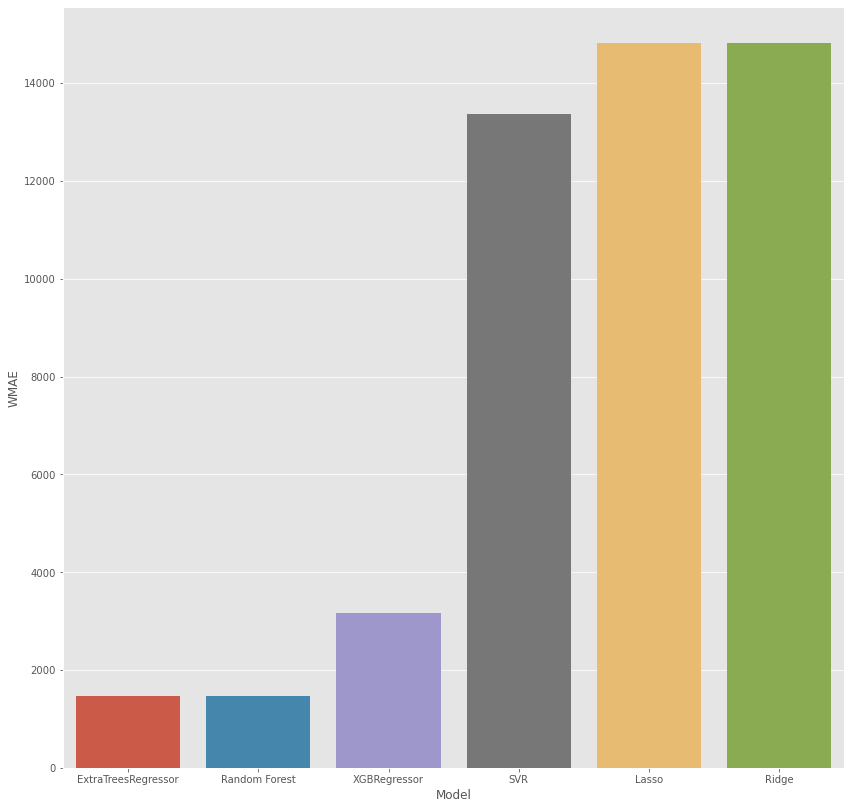

In [135]:
plt.figure(figsize = (14,14))
sns.barplot(data = baseline_df, x = 'Model', y = 'WMAE')